In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib nbagg

//anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
from astropy.io import fits

In [3]:
cd ~/Galactic_Center/acisI_merged/

/Users/lia/Galactic_Center/acisI_merged


In [4]:
def trim_events(events, xmin=0,xmax=10000,ymin=0,ymax=10000,emin=300,emax=10000):
    ix = (events['x'] >= xmin) & (events['x'] <= xmax)
    iy = (events['y'] >= ymin) & (events['y'] <= ymax)
    ie = (events['energy'] >= emin) & (events['energy'] <= emax)
    result = events[ix&iy&ie]
    return result

In [5]:
EVTFILE = '13016_reproj_evt.fits'
OBSID   = '13016_'

hdulist = fits.open(EVTFILE, memmap=True)
events  = hdulist[1].data
hdulist.close()

events = trim_events(events)

In [6]:
from scipy.interpolate import RectBivariateSpline

In [7]:
## NEED TO CHECK if this corner and maxvals are being treated correctly 
## I checked and it worked for ObsId 13016; I'm still concerned about using this in general

def load_expmap(file, image=False):
    hdulist = fits.open(file, memmap=True)
    expmap_img = hdulist[0].data
    hdulist.close()
    
    CORNER  = (2650,2691) # physical x,y coordinates for image 0,0
    MAXVALS = (5488,5462)  # physical x,y coordinates for image 2838,2771
    xgrid   = np.arange(expmap_img.shape[1]) * (MAXVALS[0]-CORNER[0])/expmap_img.shape[1] + CORNER[0]
    ygrid   = np.arange(expmap_img.shape[0]) * (MAXVALS[1]-CORNER[1])/expmap_img.shape[0] + CORNER[1]

    assert (ygrid.shape[0],xgrid.shape[0]) == expmap_img.shape
    
    if image: return (xgrid, ygrid, expmap_img)
    else: return RectBivariateSpline(xgrid, ygrid, expmap_img.T)

In [8]:
EXPMAP = OBSID+'2.0-8.0_thresh.expmap'
xgrid, ygrid, expmap_img = load_expmap(EXPMAP, image=True)
expmap = load_expmap(EXPMAP)

<IPython.core.display.Javascript object>


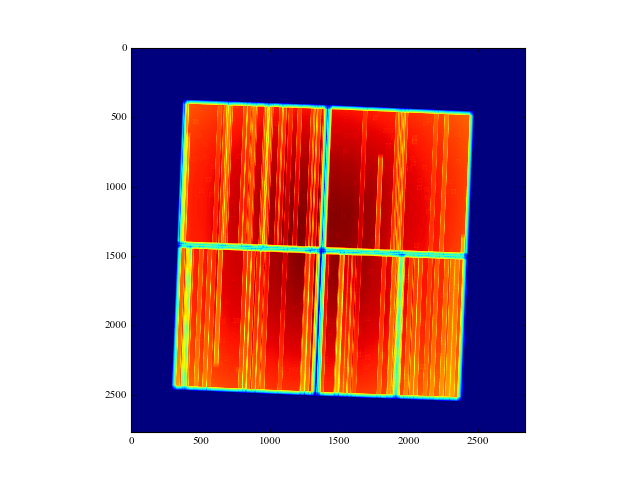

In [9]:
plt.figure()
plt.imshow(expmap_img)
plt.show()

In [10]:
## Get all the maps

# There is something strange about the 1.1-2.1 keV map, ignore for now
EXPEDGES = [(2.1,2.8),(2.8,3.5),(3.5,4.2),(4.2,6.0),(6.0,7.0),(7.0,8.0)]
EXPFILES = [OBSID+"%.1f-%.1f_thresh.expmap" % edge for edge in EXPEDGES]

#EXPMAPS = [load_expmap(f, image=True) for f in EXPFILES]
EXPMAPBV = [load_expmap(f) for f in EXPFILES]

In [11]:
from matplotlib.colors import LogNorm

In [12]:
def energy_bin_image( emin, emax, nbins=200 ):
    ie = ( events['energy']/1.e3 >= emin ) & ( events['energy']/1.e3 <= emax )
    H, xedges, yedges = np.histogram2d( events['x'][ie], events['y'][ie], bins=(nbins,nbins))
    im = plt.imshow(H, interpolation='nearest', origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', norm=LogNorm() )
    cbar = plt.colorbar(label='counts')
    return (H, xedges, yedges)

<IPython.core.display.Javascript object>


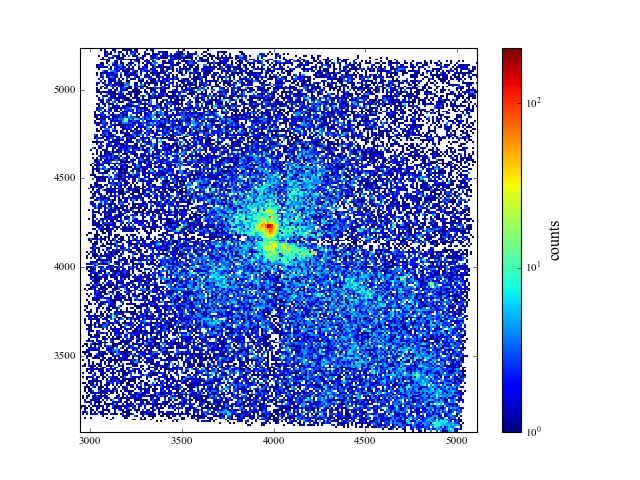

In [13]:
plt.figure()
energy_bin_image(2.0,8.0);

## Zoom in on data set of interest

In [14]:
zoomin = trim_events(events, xmin=4000,xmax=4200,ymin=4000,ymax=4200,emin=2400,emax=7500)
data = np.vstack((zoomin['x'],zoomin['y'],zoomin['energy'])).T

In [15]:
data.shape

(5289, 3)

In [16]:
from scipy.spatial import Delaunay

In [17]:
%%time
dtes = Delaunay(data, incremental=True)

CPU times: user 178 ms, sys: 6.11 ms, total: 184 ms
Wall time: 184 ms


In [18]:
data[0], data[dtes.simplices[0]]

(array([ 4120.41699219,  4045.24658203,  6683.31445312], dtype=float32),
 array([[ 4038.04638672,  4128.5234375 ,  7340.296875  ],
        [ 4001.94189453,  4115.41015625,  7262.84423828],
        [ 4027.64160156,  4003.34472656,  7272.00683594],
        [ 4047.24951172,  4057.74462891,  7464.26611328]], dtype=float32))

** How does this tessellation object work? **

In [19]:
(indices, indptr) = dtes.vertex_neighbor_vertices

In [20]:
indices.shape, indptr.shape

((5290,), (79238,))

In [21]:
data[0], data[[indptr[indices[0]:indices[1]]]]

(array([ 4120.41699219,  4045.24658203,  6683.31445312], dtype=float32),
 array([[ 4143.67138672,  4077.19238281,  6672.59521484],
        [ 4124.51171875,  4051.54052734,  6627.34863281],
        [ 4118.60791016,  4029.08837891,  6639.78662109],
        [ 4112.34960938,  4061.09033203,  6631.71240234],
        [ 4110.99902344,  4060.00244141,  6687.97412109],
        [ 4106.3125    ,  4025.85009766,  6672.02636719],
        [ 4149.49902344,  4065.71948242,  6687.17822266],
        [ 4159.22363281,  4018.88452148,  6654.94970703],
        [ 4108.48876953,  4031.3503418 ,  6718.80029297],
        [ 4135.51171875,  4033.40039062,  6737.38427734],
        [ 4177.08935547,  4045.30908203,  6678.84179688]], dtype=float32))

In [22]:
test = dtes.vertex_to_simplex

In [23]:
test.shape

(5289,)

In [24]:
data[0], data[dtes.simplices[test[0]]]

(array([ 4120.41699219,  4045.24658203,  6683.31445312], dtype=float32),
 array([[ 4120.41699219,  4045.24658203,  6683.31445312],
        [ 4143.67138672,  4077.19238281,  6672.59521484],
        [ 4124.51171875,  4051.54052734,  6627.34863281],
        [ 4118.60791016,  4029.08837891,  6639.78662109]], dtype=float32))

In [25]:
dtes.simplices[0]

array([3641,  854, 2722,  872], dtype=int32)

In [26]:
data[0]

array([ 4120.41699219,  4045.24658203,  6683.31445312], dtype=float32)

In [30]:
def get_vertex_triangles(p):
    test = np.any( data[dtes.simplices] == p, axis=2 )
    return dtes.simplices[np.where(test)[0]]

# To get verticies, run data[get_vertex_triangles(p)]

In [33]:
'''from multiprocessing import Pool
mypool = Pool(processes=6)

%%time
trianges = mypool.map(get_vertex_triangles, data)'''

In [31]:
%%time
trianges = [get_vertex_triangles(p) for p in data]

CPU times: user 28.2 s, sys: 70.9 ms, total: 28.2 s
Wall time: 28.3 s


With vertices $a, b, c, d$, the volume of the tetrahedron is 

$$ V = \frac{|(a-d) \cdot ((b-d) \times (c-d))|}{6} $$

In [32]:
def get_triangle_volume(triangle):
    a, b, c, d = triangle
    assert len(a) == len(b) == len(c) == len(d) == 3
    numerator = np.dot(a-d, np.cross(b-d,c-d))
    return np.abs(numerator)/6.0

In [33]:
data[trianges[0][0]]

array([[ 4120.41699219,  4045.24658203,  6683.31445312],
       [ 4143.67138672,  4077.19238281,  6672.59521484],
       [ 4124.51171875,  4051.54052734,  6627.34863281],
       [ 4118.60791016,  4029.08837891,  6639.78662109]], dtype=float32)

In [34]:
get_triangle_volume(data[trianges[0][0]])

2980.7506510416665

In [35]:
def get_point_dens(i):
    result = 0.0
    for t in data[trianges[i]]:
        result += get_triangle_volume(t)
    return 4.0/result

# In general, should be D+1/result where D is dimensionality of data set

In [36]:
get_point_dens(0)

3.5336882623350805e-05

In [37]:
density_maps = np.array([get_point_dens(i) for i in range(len(data))])

In [38]:
gridx = np.linspace(4000,4200,200)
gridy = np.linspace(4000,4200,200)
grid = np.meshgrid( gridx, gridy )

In [39]:
from scipy.interpolate import griddata

In [40]:
grid_x, grid_y, grid_z = np.mgrid[4050:4150:100j, 4050:4150:100j, 2500:7500:100j]
gridtest = griddata(data, density_maps, (grid_x,grid_y,grid_z), method='linear')

In [41]:
from scipy.interpolate import interp1d

In [42]:
def dirty_interp():
    zgrid    = np.array([np.mean(x) for x in EXPEDGES])
    mapvals  = np.array([mapinterp.ev(grid_x[0],grid_y[0]) for mapinterp in EXPMAPBV])
    return interp1d(zgrid, mapvals, axis=0)

In [43]:
emap_interp = dirty_interp()

In [44]:
grid_z[0,0,10]/1.e3

3.0050505050505052

<IPython.core.display.Javascript object>


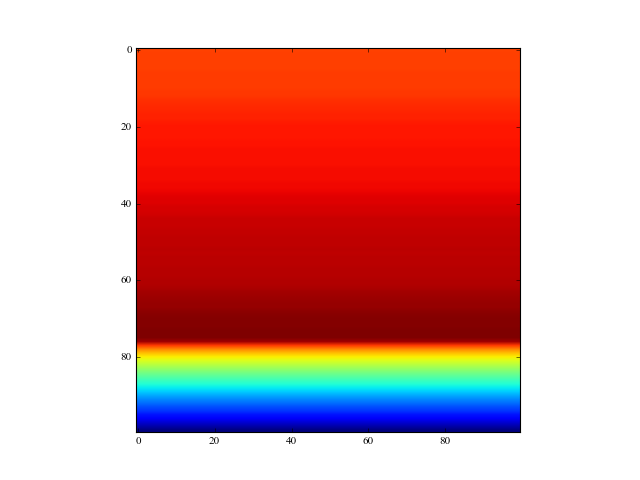

In [45]:
plt.figure()
plt.imshow(emap_interp(grid_z[0,0,1]/1.e3))

In [46]:
gridtest[:,:,1].shape, emap_interp(grid_z[0,0,10]/1.e3).shape

((100, 100), (100, 100))

In [49]:
def show_image(i):
    #extent=[grid_x[0,0][0], grid_x[-1,-1][0], grid_y[0,0][0], grid_y[-1,-1]][0],
    #gridtest[:,:,i]/expmap.ev(grid_x[:,:,0],grid_y[:,:,0]), 
    result = plt.imshow(gridtest[:,:,i]/emap_interp(grid_z[0,0,i]/1.e3), 
             extent=[4050,4150,4050,4150], norm=LogNorm())
    cbar = plt.colorbar(label='phot/s/cm$^2$/keV/pix')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(r'E = %.2f' % (grid_z[0,0][i]/1.e3))
    return result

<IPython.core.display.Javascript object>


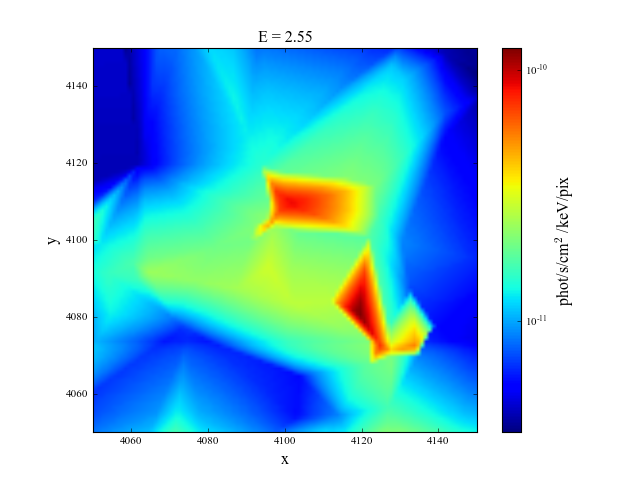

In [50]:
plt.figure()
test = show_image(1)
plt.show()

In [51]:
from matplotlib import animation

<IPython.core.display.Javascript object>


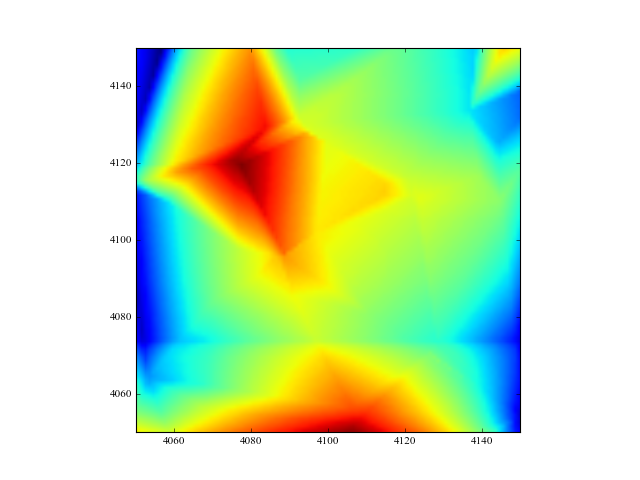

In [52]:
fig = plt.figure()

def f(i):
    return gridtest[:,:,i]/emap_interp(grid_z[0,0,i]/1.e3)
    #return gridtest[:,:,i]/expmap.ev(grid_x[:,:,0],grid_y[:,:,0])

ims = []
for i in range(len(grid_z[:,:,0])):
    im = plt.imshow(f(i),extent=[4050,4150,4050,4150], norm=LogNorm())
    #cbar = plt.colorbar(label='phot/s/cm$^2$/keV/pix')
    #plt.xlabel('x')
    #plt.ylabel('y')
    #plt.title(r'E = %.2f' % (grid_z[0,0][i]/1.e3))
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=1000)
plt.show()

In [53]:
import matplotlib.animation as manimation

In [61]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
        comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig = plt.figure()
l, = plt.plot([], [], 'k-o')

plt.xlim(4050, 4150)
plt.ylim(4050, 4150)

#x0,y0 = 0, 0

with writer.saving(fig, "writer_test.mp4", 100):
    for i in range(100):
        show_image(i)
        writer.grab_frame()


RuntimeError: No MovieWriters available!